In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
# Set constants
pi = math.pi
viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return -torch.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.size()[0]
    return torch.zeros((n,1), dtype=torch.float32)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

N_0 = 64
N_b = 64
N_r = 1024 * 8

tmin = 0
tmax = 1.0
xmin = -1.0
xmax = 1.0

lb = torch.as_tensor([tmin, xmin], dtype = torch.float32)
ub = torch.as_tensor([tmax, xmax], dtype = torch.float32)

# initial boundary data
t_0 = torch.ones((N_0, 1), dtype = torch.float32) * lb[0]
x_0 = torch.distributions.uniform.Uniform(lb[1], ub[1]).sample((N_0, 1))
X_0 = torch.concat([t_0, x_0], dim = 1)

u_0 = fun_u_0(x_0)

# boundary data
t_b = torch.distributions.uniform.Uniform(lb[0], ub[0]).sample((N_b, 1))
x_b = lb[1] * (ub[1] - lb[1]) * torch.distributions.bernoulli.Bernoulli(0.5).sample((N_b,1))
X_b = torch.concat([t_b, x_b], dim = 1)

u_b = fun_u_b(t_b, x_b)

# collocation points
t_r = torch.distributions.uniform.Uniform(lb[0], ub[0]).sample((N_r, 1))
x_r = torch.distributions.uniform.Uniform(lb[1], ub[1]).sample((N_r, 1))
X_r = torch.concat([t_r, x_r], dim = 1)

X_data = [X_0, X_b]
u_data = [u_0, u_b]

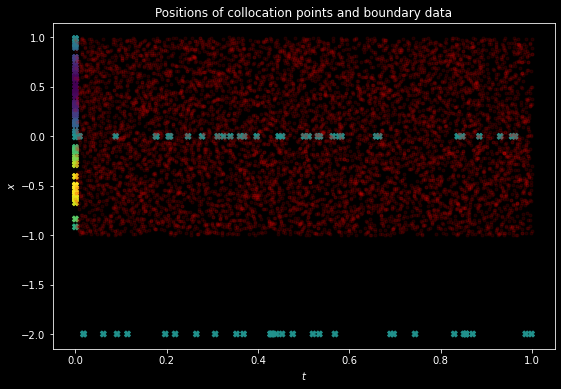

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

  0%|          | 0/1024 [00:00<?, ?it/s]

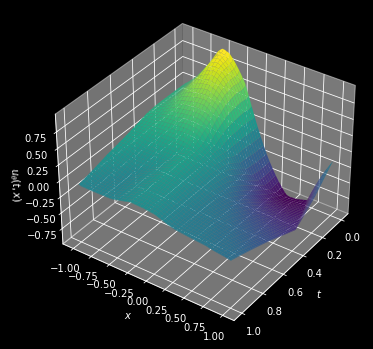

In [ ]:
class PINN(nn.Module):
    def __init__(self, lb, ub, input_dim : int = 2, output_dim : int = 1, hidden_dim : int = 32):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        self.lb = lb
        self.ub = ub
    def forward(self, x : torch.Tensor):
        x = 2.0 * (x-self.lb) / (self.ub - self.lb) - 1
        return self.layer(x)

from typing import List
from tqdm.auto import tqdm
from torch.optim import RMSprop

class PINNSolver():
    def __init__(self, model : nn.Module, X_r : torch.Tensor, X_data : List, u_data : List):
        self.model = model
        
        X_r.requires_grad = True
        
        self.t = X_r[:,0]
        self.x = X_r[:,1]
        self.x_data = X_data
        self.u_data = u_data
        
        self.hist = []
        self.iter = 0
        
        self.optimizer = RMSprop(model.parameters(), lr = 1e-3)
        
    def gradient(self, u : torch.Tensor, x : torch.Tensor):
        u_x = torch.autograd.grad(u, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph = True)[0]
        return u_x
    
    def compute_PINN_loss(self):
        t = self.t.view(-1,1)
        x = self.x.view(-1,1)
        
        u = self.model(torch.concat([t, x], dim = 1))
        u_x = self.gradient(u,x)
        u_t = self.gradient(u,t)
        u_xx = self.gradient(u_x, x)
        
        return fun_r(t, x, u, u_t, u_x, u_xx)
    
    def compute_mse_loss(self):
        
        loss = 0
        for i in range(len(self.x_data)):
            x_data = self.x_data[i]
            u_data = self.u_data[i]
            u_pred = self.model(torch.concat([x_data], dim = 1))
            loss += torch.norm(u_pred - u_data)

        return loss
    
    def compute_loss(self):
        pinn_loss = self.compute_PINN_loss()
        pinn_loss = torch.mean(pinn_loss)
        mse_loss = self.compute_mse_loss()
        
        return pinn_loss + mse_loss
    
    def train(self, n_epoch : int = 32):
        
        self.model.train()
        
        for i in tqdm(range(n_epoch)):
            self.optimizer.zero_grad()
            loss = self.compute_loss()
            loss.backward()
            self.optimizer.step()
        
    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        
        self.model.eval()
        with torch.no_grad():
            upred = self.model(torch.from_numpy(Xgrid).float())
            
        U = upred.detach().numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        plt.savefig("./result.png")
        return ax
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax
    
model = PINN(lb, ub, 2, 1, 128)
solver = PINNSolver(model, X_r, X_data, u_data)
solver.train(n_epoch=5000)
ax = solver.plot_solution()